# MadMiner tutorial for Parton-Level Analysis

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

Before you execute this notebook, make sure you have running installations of MadGraph. In addition, MadMiner and LHEMiner have to be in your PYTHONPATH.

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.tools.plots import plot_2d_morphing_basis
from madminer.refinery import combine_and_shuffle

from lheprocessor.lheprocessor import LHEProcessor

Please enter here the path to your MG5 root directory.

In [3]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [4]:
miner = GoldMine()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

18:15  
18:15  ------------------------------------------------------------
18:15  |                                                          |
18:15  |  MadMiner                                                |
18:15  |                                                          |
18:15  |  Version from August 13, 2018                            |
18:15  |                                                          |
18:15  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:15  |                                                          |
18:15  ------------------------------------------------------------
18:15  
18:15  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-50.0, 50.0))
18:15  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-50.0, 50.0))


## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [5]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)
miner.add_benchmark(
    {'CWL2':50., 'CPWL2':0.},
    'w2'
)

18:15  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
18:15  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
18:15  Added benchmark w2: CWL2 = 50.00, CPWL2 = 0.00e+00)


### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [6]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

18:15  Optimizing basis for morphing
18:15  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
18:15  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
18:15  Added benchmark w2: CWL2 = 50.00, CPWL2 = 0.00e+00)
18:15  Added benchmark morphing_basis_vector_3: CWL2 = -1.53e+01, CPWL2 = -3.99e+01)
18:15  Added benchmark morphing_basis_vector_4: CWL2 = 39.99, CPWL2 = -2.61e+01)
18:15  Added benchmark morphing_basis_vector_5: CWL2 = -2.22e+01, CPWL2 = 40.20)


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

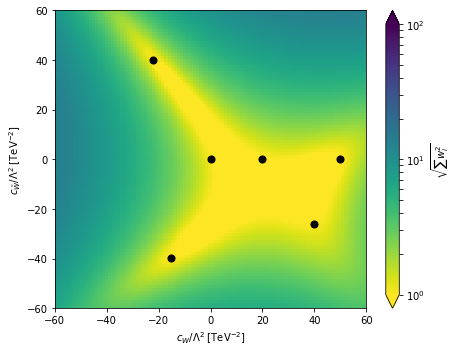

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

## 4. Change UFO Model to include detector smearing

To simulate the resolution of the invariant masses due to detector smearing, we use a simple trick: we change the Higgs propagator to reproduce the wanted (smeared) invariant mass distribution. The following example illustrates how to change the UFO model `EWdim6` to reproduce the invariant mass distribution for $H\to\gamma\gamma$. 

1. We base our simulation of detector effects on the CMS simulation in Fig. 6 (right) of [CMS-PAS-HIG-15-005](https://cds.cern.ch/record/2140979). In particular, we describe the peak region of the $H\to\gamma\gamma$ diphoton mass distribution by a Gaussian 

    \begin{equation}
    Gaus\left(m~|~N,m_H,\sigma\right)=\frac{N}{\sqrt{2\pi}\sigma}\text{Exp}\left[-\frac{1}{2} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation}
    
    From a fit to the normalized distribution we obtain: $N=0.92$, $m_H=124.7$ and $\sigma=1.67$. The normalization factor $N$ accounts for the fact, that a gaussian does not describe the tails of the dsitribition well. However, these tails will hardly contribute to the information and we account for the loss of signal rate in these tails through the normalization factor $N$. 


2. We now replace the usual Breit-Wigner propagator with the (square-root) of the Gaussian distribution: 
    
    \begin{equation} 
    \frac{1}{p^2-m_H^2+i \Gamma m_H} \rightarrow \big[\frac{N}{N_{BW}}\frac{1}{\sqrt{2\pi}\sigma}\big]^{1/2} \text{Exp}\left[-\frac{1}{4} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation} 
    
    The normalization of the Breit-Wigner is given by  $N_{BW}\approx 2 m_H^2 \Gamma_H / \pi $.  (Here I used $\Gamma_H \ll m_H$. For full formula see [Wikipedia](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution)). 
    
    This can simply be implemented in the file `propagators.py` of the UFO model. First define the new propagator. Here I use the values obtained from the fit above and choose the prefactor $(\sqrt{2\pi}\sigma N_{BW} / N)^{1/2} = 12.438$ 
    
    `denominator_Higgs="12.438*cmath.exp(0.25*(cmath.sqrt(P('mu',id)*P('mu',id))-124.7)**2/1.5245**2)" `
    
    Assign the new propagator to to the scalar particles  
    
    `S = Propagator(name = "S",numerator = "complex(0,1)",denominator = denominator_Higgs)`


3. By defaukt, MadGraph doesn't use the content of `propagators.py`. So we have to make sure it's used. This can simply be done by changing the particle information in the `particles.py` file of the UFO model

    `H = Particle(pdg_code = 25, name = 'H', ... , propagator = Prop.S)`
    
    
4. Finally, we will change the `bwcutoff` in `run_card.dat` to ensure that MadGraph integrated over the desired range. The choice of `bwcutoff` depends on the choosen value of the Higgs width in the `param_card.dat`. For $\Gamma_H=4.07$ MeV I would suggest to choose `bwcutoff=2000`, which then covers an integration range of $m_H \pm 2000\times \Gamma_H = 116.9\dots 133.1$ GeV. 

    Note: if you get an error message such as `IEEE_UNDERFLOW_FLAG` or `IEEE_DENORMAL`, it probably means you have choosen a too large value for `bwcutoff`

## 4. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [8]:
miner.save('data/madminer_example.h5')

18:15  Saving setup (including morphing) to data/madminer_example.h5


In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first. Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [9]:
miner.run(
    mg_directory=mg_dir,
    proc_card_file='cards/proc_card_parton.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card_parton.dat',
    sample_benchmark='sm',
    initial_command='source ~/.bashrc'
)

18:15  Generating MadGraph process folder from cards/proc_card_parton.dat at ./MG_process
18:15  Creating param and reweight cards in ./MG_process
18:15  Starting MadGraph and Pythia in ./MG_process


## 5. Extras Parton Level Observables / Weights 

Here we extract the parton level information (observables and weights) from the .lhe file. This is done with the LHEProcessor package. 

In [10]:
lhep = LHEProcessor()

18:17  
18:17  ------------------------------------------------------------
18:17  |                                                          |
18:17  |  DelphesProcessor                                        |
18:17  |                                                          |
18:17  |  Version from August 13, 2018                            |
18:17  |                                                          |
18:17  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:17  |                                                          |
18:17  ------------------------------------------------------------
18:17  
18:17  Hi! How are you today?


After creating the object, one can add a number of LHE event samples.

In [11]:
lhep.add_lhe_sample('MG_process/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark="sm")

18:17  Adding LHE sample at MG_process/Events/run_01/unweighted_events.lhe.gz


We also want to specify the Benchmark names, because sometimes the order is mixed up in the LHE files. But fortunately, we already stored them in the HDF5 file. 

In [12]:
lhep.read_benchmark_names('data/madminer_example.h5')

Not let's define some observables. The `p[i]` correspond to the i'th parton momentum as specified when generating the process.  All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [13]:
lhep.add_observable('pt_j1', 'p[0].pt')
lhep.add_observable('pt_j2', 'p[1].pt')
lhep.add_observable('m_jj', '(p[0] + p[1]).m')
lhep.add_observable('m_aa', '(p[2] + p[3]).m')

18:17  Adding (not required) observable pt_j1 = p[0].pt
18:17  Adding (not required) observable pt_j2 = p[1].pt
18:17  Adding (not required) observable m_jj = (p[0] + p[1]).m
18:17  Adding (not required) observable m_aa = (p[2] + p[3]).m


The function `analyse_lhe_samples` extracts all these observables and weights from the LHE file(s) 

In [14]:
lhep = LHEProcessor()
lhep.add_lhe_sample('MG_process/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark='sm')
lhep.read_benchmark_names('data/madminer_example.h5')
lhep.add_observable('pt_j1', 'p[0].pt')
lhep.add_observable('pt_j2', 'p[1].pt')
lhep.add_observable('m_jj', '(p[0] + p[1]).m')
lhep.add_observable('m_aa', '(p[2] + p[3]).m')

lhep.analyse_lhe_samples()

18:17  
18:17  ------------------------------------------------------------
18:17  |                                                          |
18:17  |  DelphesProcessor                                        |
18:17  |                                                          |
18:17  |  Version from August 13, 2018                            |
18:17  |                                                          |
18:17  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:17  |                                                          |
18:17  ------------------------------------------------------------
18:17  
18:17  Hi! How are you today?
18:17  Adding LHE sample at MG_process/Events/run_01/unweighted_events.lhe.gz
18:17  Adding (not required) observable pt_j1 = p[0].pt
18:17  Adding (not required) observable pt_j2 = p[1].pt
18:17  Adding (not required) observable m_jj = (p[0] + p[1]).m
18:17  Adding (not required) observable m_aa = (p[2] + p[3]).m
18:17  Analysing LHE sampl

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [15]:
lhep.save('data/madminer_example_with_lhedata.h5', 'data/madminer_example.h5')

18:17  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_lhedata.h5


Let's make a quick cross check by plotting a distributions

The total cross section is: 10.505 pb


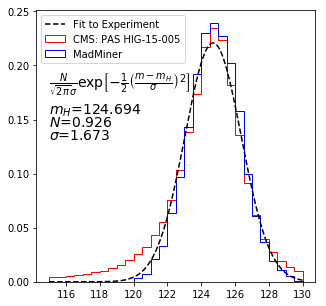

In [22]:
#Define my fitting function
def myfunction(x, mean, amplitude, standard_deviation):
    return amplitude/np.sqrt(2.0*3.1415*standard_deviation**2) * np.exp( - 0.5*((x - mean) / standard_deviation) ** 2)

#Function to do the plotting
def smearing_validation_plot(filename,lheprocessor,inputrange,label):
    
    #Get Data from Experiment / MadMiner
    exp_data , exp_weights = np.loadtxt(filename)[:,0] , np.loadtxt(filename)[:,1]
    madminer_data , madminer_weights = lheprocessor.observations['m_aa'] , lheprocessor.weights[0]

    #Plot Exp. Data
    fig = plt.figure(figsize=(5,5))
    bin_heights, bin_borders, _ = plt.hist(exp_data, weights=exp_weights,normed=True,
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
        histtype='step',color='Red',label=label)

    #Fit to Experiment
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    bestfit, _ = curve_fit(myfunction, bin_centers, bin_heights, p0=[125, 1, 1])
    fitplotrange=np.arange(inputrange[0], inputrange[1], 0.01)
    plt.plot(fitplotrange,myfunction(fitplotrange,bestfit[0],bestfit[1],bestfit[2]),
        color='Black',linestyle='dashed', label='Fit to Experiment')
    
    #Plot MadMiner
    norm = sum(madminer_weights)
    print ('The total cross section is: %.3f pb'%(norm),)
    bin_heights_mm, _ , _ = plt.hist(madminer_data,
        weights = madminer_weights/norm*inputrange[2]/(inputrange[1]-inputrange[0])*bestfit[1],
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
         histtype='step',color='Blue',label='MadMiner')  

    #Finish Plot
    plt.legend(loc='upper left')
    upperbound=max(max(bin_heights),max(bin_heights_mm))
    plt.text(inputrange[0],0.75*upperbound,
         r'$\frac{N}{\sqrt{2\pi}\sigma}\exp\left[-\frac{1}{2}\left(\frac{m-m_H}{\sigma}\right)^2\right]$',
         fontsize=14)
    plt.text(inputrange[0],0.65*upperbound,r'$m_H$=%.3f'%(bestfit[0]),fontsize=14)
    plt.text(inputrange[0],0.60*upperbound,r'$N$=%.3f'%(bestfit[1]),fontsize=14)
    plt.text(inputrange[0],0.55*upperbound,r'$\sigma$=%.3f'%(bestfit[2]),fontsize=14)

    plt.show()

#Call Function
smearing_validation_plot('smearing_data/h_2_aa.txt',lhep,[115,130,30],'CMS: PAS HIG-15-005')